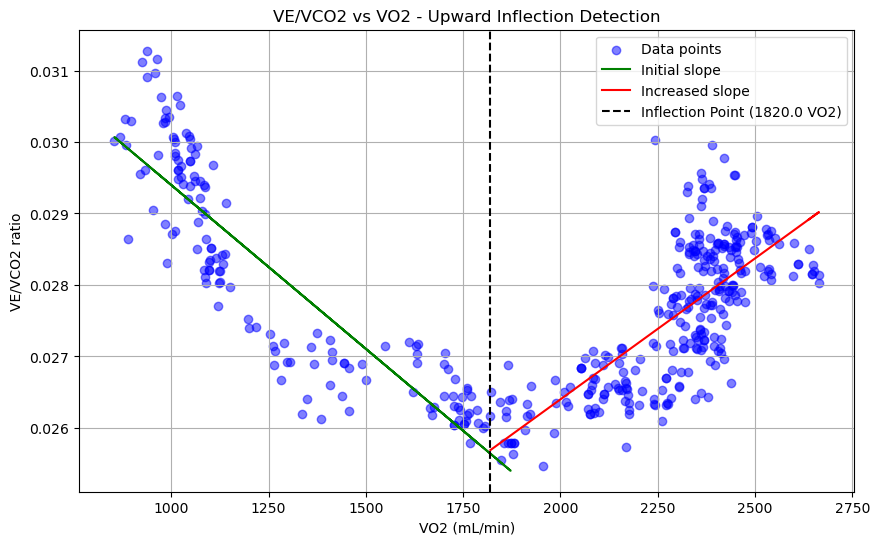


Filtered data to time <= 402.0s (VO2 <= 1820.0)
Original data points: 437, Filtered data points: 152

~ VENTILATORY THRESHOLD RESULTS (FILTERED DATA) ~~
• VEQ:            1457.0 mL/min  |  Time: 325.0s (26.1%)
• V-Slope:        1337.0 mL/min  |  Time: 309.0s (24.5%)
--------------------------------------------------
 MAXIMUM VO2:    2664.0 ML/MIN



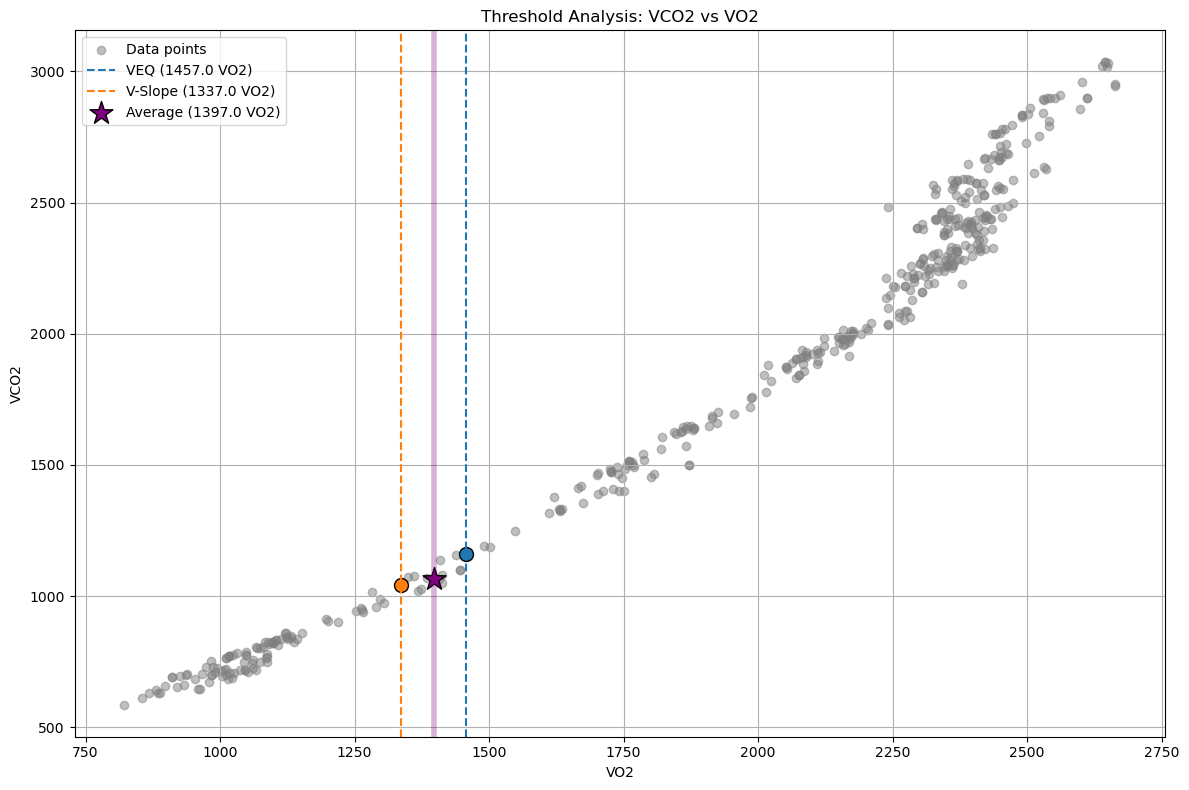

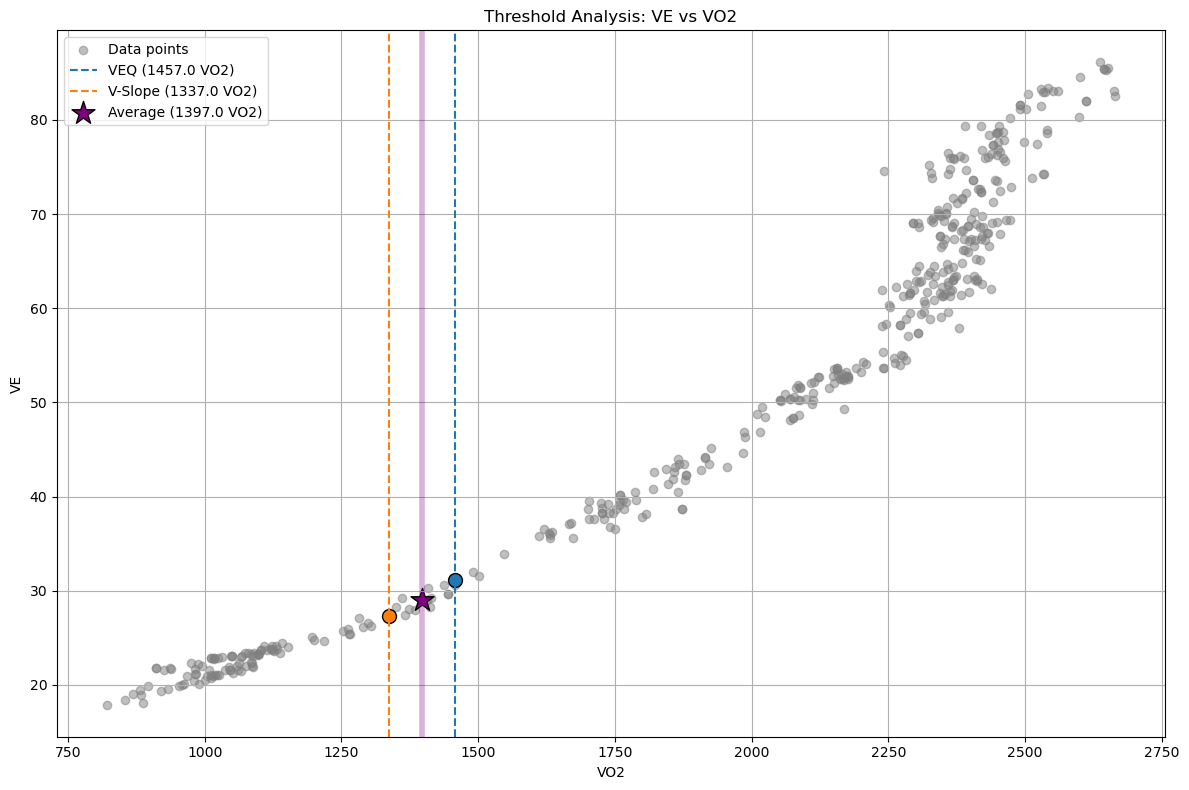

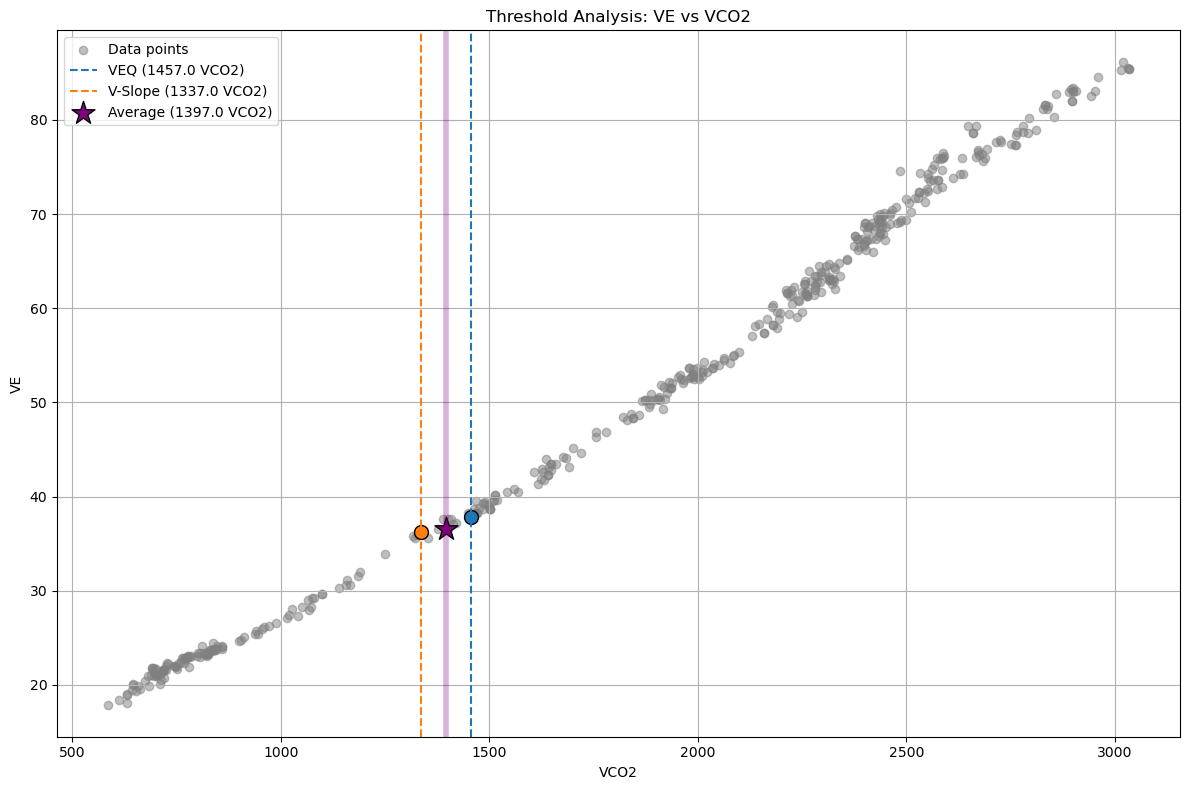

/tmp/ipykernel_3032229/1184399904.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ve_VO2_ratio'] = data['VE'] / data['VO2']


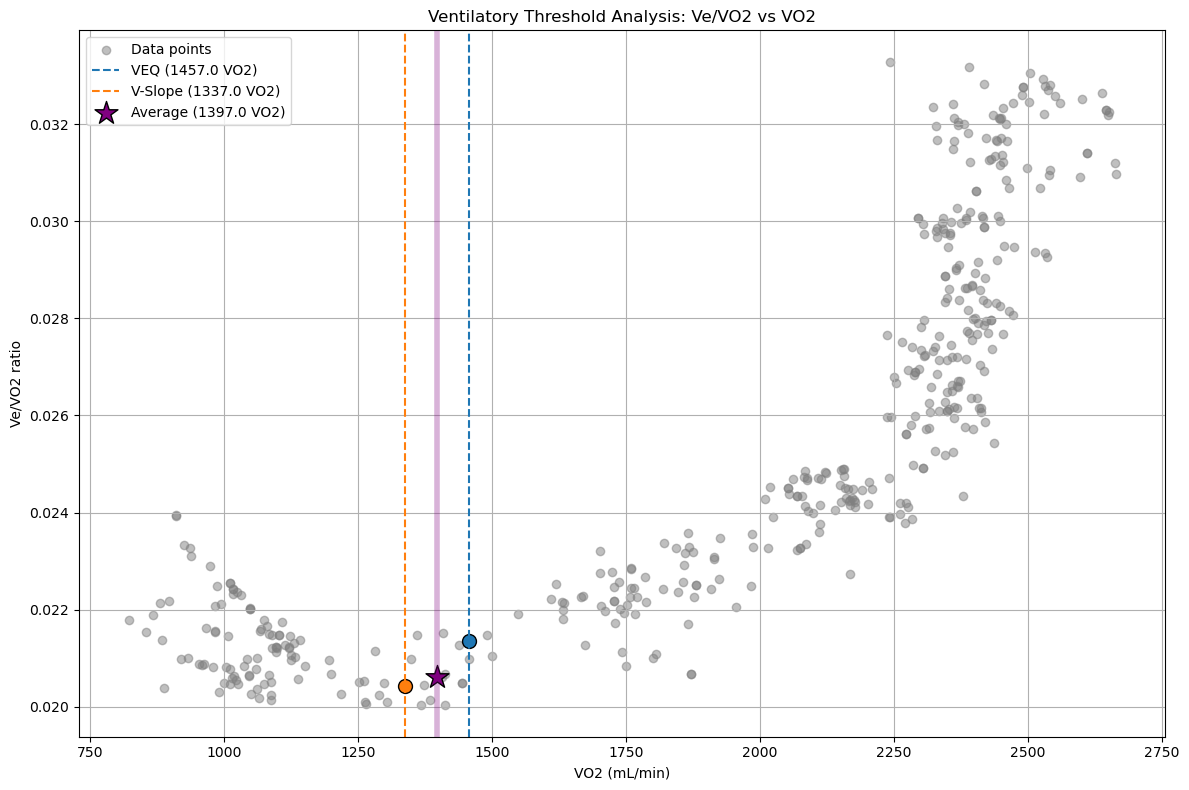

/tmp/ipykernel_3032229/1184399904.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ve_VCO2_ratio'] = np.where(


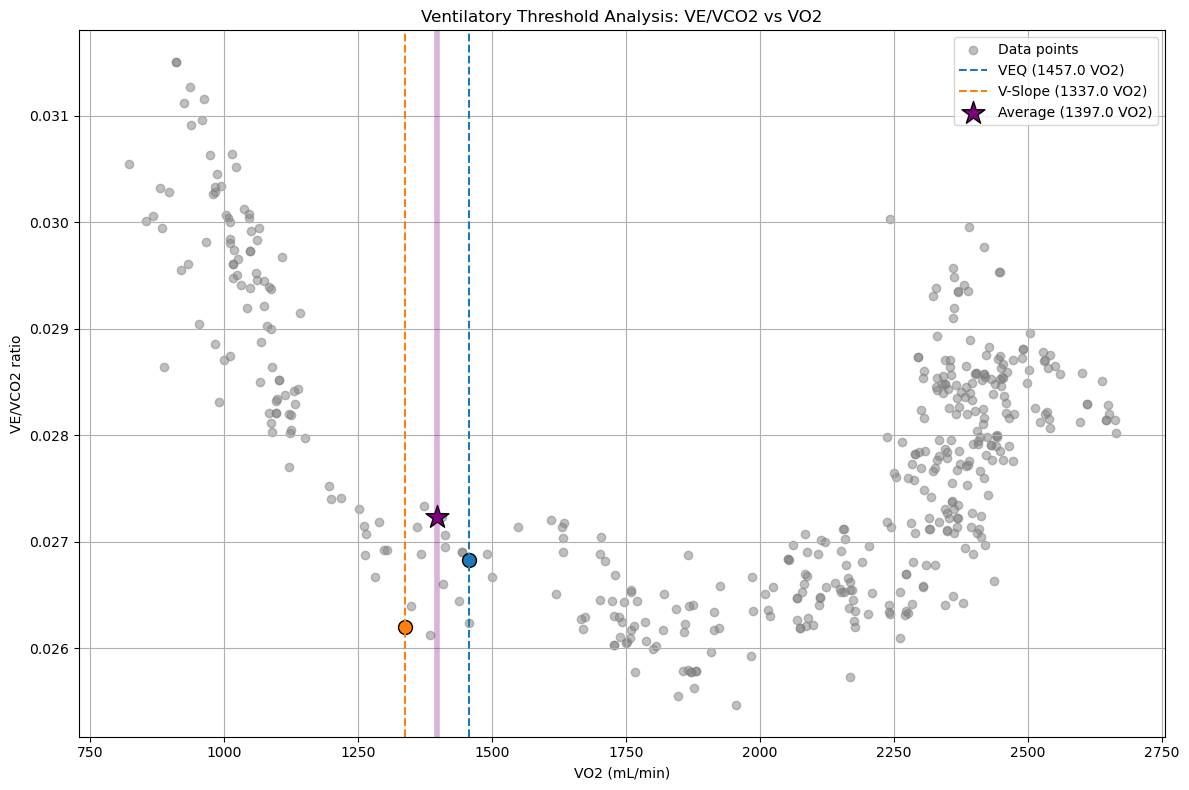

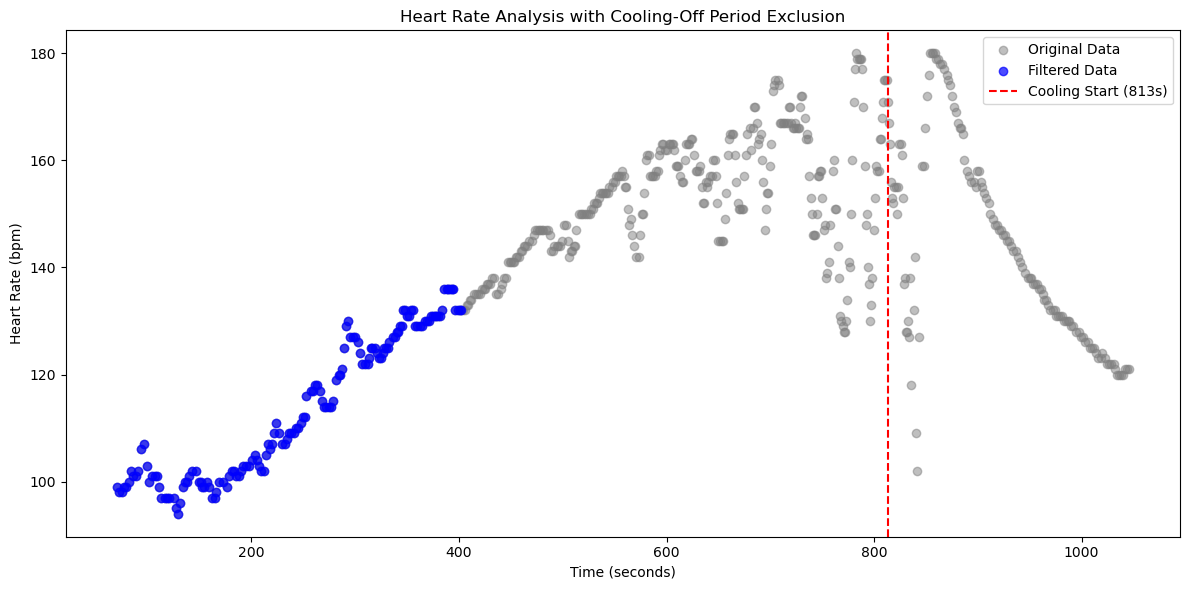

In [21]:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import IsolationForest
    from scipy.signal import savgol_filter
    from sklearn.linear_model import HuberRegressor


    # Constants
    CONTAMINATION_LEVEL = 0.005
    INITIAL_IGNORE_TIME = 70  # seconds
    COOLING_DROP_PCT = 5  # percentage drop from max HR to trigger cooling period
    COOLING_MIN_DURATION = 30  # seconds

    def load_data(data_path, test_id):
        """Load and prepare the dataset, returns data_before_cooling and cooling_start_time"""
        data = pd.read_csv(data_path)
        subset = data[data['ID_test'] == test_id].sort_values('time') # filtering data set as per the test_ID selected

        # Apply initial time exclusion
        if INITIAL_IGNORE_TIME > 0:
            subset = subset[subset['time'] >= INITIAL_IGNORE_TIME]   # filtering data from before start time 

        # Drop rows with missing essential values including HR
        subset = subset.dropna(subset=['VO2', 'VE', 'VCO2', 'time', 'HR']) # removing nulls

        # Detect cooling-off period based on HR drop
        times = subset['time'].values
        hr = subset['HR'].values
        cooling_start_time = None

        if len(hr) < 3:
            return subset, cooling_start_time  # Not enough data for analysis

        # Smooth HR data
        window_size = min(11, len(hr))
        if window_size % 2 == 0:
            window_size -= 1  # Ensure window size is odd
        if window_size >= 3:
            smoothed_hr = savgol_filter(hr, window_size, 2)
        else:
            smoothed_hr = hr

        max_hr_idx = np.argmax(smoothed_hr)
        max_hr = smoothed_hr[max_hr_idx]
        threshold_hr = max_hr * (1 - COOLING_DROP_PCT / 100) # threshold deterimined to be 95% of peak HR

        # Find cooling start time
        for i in range(max_hr_idx, len(times)):
            current_time = times[i]
            if smoothed_hr[i] < threshold_hr:
                end_time = current_time + COOLING_MIN_DURATION
                mask = (times >= current_time) & (times <= end_time)
                if len(smoothed_hr[mask]) == 0:
                    continue
                if np.all(smoothed_hr[mask] < threshold_hr):
                    cooling_start_time = current_time
                    break
        # loop scans heart rate to detect when HR drops below a threshold (5% below max) 
        # and stays there for at least 30 seconds.

        return subset, cooling_start_time

    
    def veq_method(data, show_plot=False):
        """
        Method 1: VEQ Method (VE/VO2 vs VO2)
        Returns the VO2 value at which VE/VO2 ratio starts to increase.
        """

#         Filter anomalies based on VE and VO2 only
        features = data[['VO2', 'VE']].dropna().values
        iso_forest = IsolationForest(contamination=CONTAMINATION_LEVEL, random_state=42)
        mask = iso_forest.fit_predict(features) == 1
        filtered_data = data.loc[mask].copy()
#         Avoid divide-by-zero errors
        filtered_data = filtered_data[filtered_data['VO2'] > 0]
   

        # Compute VE/VO2 ratio
        filtered_data['VE_VO2'] = filtered_data['VE'] / filtered_data['VO2']
        x = filtered_data['VO2'].values
        y = filtered_data['VE_VO2'].values

        # Sort by VO2 to ensure consistent order
        sorted_indices = np.argsort(x)
        x = x[sorted_indices]
        y = y[sorted_indices]

        def find_best_split(x, y, min_points=5):
            best_split, min_error = None, float('inf')
            for i in range(min_points, len(x) - min_points):
                # Fit robust regressions
                model1 = HuberRegressor().fit(x[:i].reshape(-1, 1), y[:i])
                model2 = HuberRegressor().fit(x[i:].reshape(-1, 1), y[i:])

                error1 = np.sum((y[:i] - model1.predict(x[:i].reshape(-1, 1)))**2)
                error2 = np.sum((y[i:] - model2.predict(x[i:].reshape(-1, 1)))**2)
                total_error = error1 + error2

                if total_error < min_error:
                    min_error = total_error
                    best_split = i

            return best_split

        split_idx = find_best_split(x, y)
        vt_vo2 = x[split_idx] if split_idx is not None else None

        if show_plot:
            plt.figure(figsize=(8, 5))
            plt.scatter(x, y, color='skyblue', s=10, label='VE/VO2 Ratio')
            if vt_vo2 is not None:
                plt.axvline(vt_vo2, color='red', linestyle='--', label=f'VEQ VT @ VO2={vt_vo2:.1f}')
            plt.xlabel('VO2 (mL/min)')
            plt.ylabel('VE/VO2 Ratio')
            plt.title('VEQ Method (VT Detection)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        return vt_vo2


    def excess_co2_method(data, show_plot=False):
        """Method 2: Excess CO2 Method"""
        vo2 = data['VO2'].values
        vco2 = data['VCO2'].values
        ve = data['VE'].values

        # Calculate excess CO2 using formula from the paper
        vo2_safe = vo2.copy().astype(float)
        vo2_safe[vo2_safe == 0] = 1e-8
        exco2 = np.where((vco2 == 0) & (vo2 == 0), 0, (vco2**2 / vo2_safe) - vco2)
        exco2 = np.nan_to_num(exco2, nan=0.0, posinf=0.0, neginf=0.0)

        # Smooth and find threshold
        window_size = min(7, len(vo2)//2*2-1)
        exco2_smooth = savgol_filter(exco2, window_size, 2) # smoothed using a Savitzky-Golay filter 
        threshold = np.median(exco2_smooth) + 0.5*np.std(exco2_smooth)  # VT identified as the first point where the smoothed exCO2 
                                                                        # exceeds calculated threshold
        vt_idx = np.argmax(exco2_smooth > threshold) if np.any(exco2_smooth > threshold) else None
        vt_vo2 = vo2[vt_idx] if vt_idx is not None else None

        if show_plot:
            plt.figure()
            plt.scatter(vo2, ve, c='darkred', label='VE vs VO2')
            if vt_vo2:
                plt.axvline(vt_vo2, color='purple', linestyle='--', label='ExCO2 VT')
            plt.title('Excess CO2 Method')
            plt.legend()
            plt.show()

        return vt_vo2


    def v_slope_method(data, show_plot=False):

        """Method 3: Modified V-slope Method"""
        # 1 minute averaging
        data = data.sort_values('time')
        data['VO2_20s'] = data['VO2'].rolling(window=1, min_periods=1, center=True).mean() # 60 second rolling average
        data['VCO2_20s'] = data['VCO2'].rolling(window=1, min_periods=1, center=True).mean()
        data = data.dropna(subset=['VO2_20s', 'VCO2_20s'])

    #     features = data[['VO2_20s', 'VCO2_20s']].values
    #     iso_forest = IsolationForest(contamination=0.10, random_state=42)
    #     outlier_labels = iso_forest.fit_predict(features)
    #     filtered_data = data[outlier_labels == 1]
    #     data = filtered_data

        # Find slope breakpoint
        def find_slope_breakpoint(df):
            X = df['VO2_20s'].values.reshape(-1, 1)
            y = df['VCO2_20s'].values
            best_break, min_bic = None, float('inf')
            min_idx, max_idx = int(len(X)*0.2), len(X) - int(len(X)*0.2)

            for i in range(min_idx, max_idx): # evaluating all potential regression lines for the split
                m1 = LinearRegression().fit(X[:i], y[:i])
                m2 = LinearRegression().fit(X[i:], y[i:])
                resid = np.concatenate([y[:i] - m1.predict(X[:i]), y[i:] - m2.predict(X[i:])])
                sigma2 = np.var(resid)
                bic = len(resid)*np.log(sigma2) + 2*np.log(len(resid)) # evaluating the fit of models using Bayesian Information Criterion 

                if (m2.coef_[0] > m1.coef_[0]) and (bic < min_bic): # findint the spot where score BIC score is lowest and slope INCREASES after break point
                    min_bic = bic
                    best_break = i

            return df.iloc[best_break] if best_break is not None else None

        vt_point = find_slope_breakpoint(data)
        vt_vo2 = vt_point['VO2_20s'] if vt_point is not None else None

        if show_plot:
            plt.figure()
            plt.scatter(data['VO2_20s'], data['VCO2_20s'], c=data['time'], cmap='viridis')
            if vt_point is not None:
                plt.scatter(vt_vo2, vt_point['VCO2_20s'], color='red', s=150, marker='*')
            plt.title('V-Slope Method')
            plt.show()

        return vt_vo2

    def calculate_average_threshold(results):
        """Calculate average of detected thresholds"""
        valid_thresholds = [vt for vt in results.values() if vt is not None]
        if not valid_thresholds:
            return None
        return np.mean(valid_thresholds)

    def plot_analysis(data, results, x_col='VO2', y_col='VE', plot_average=True):
        """
        Parameters:
        - data: DataFrame containing the data
        - results: Dictionary of threshold detection results {method_name: threshold_value}
        - x_col: Column name for x-axis (default 'VO2')
        - y_col: Column name for y-axis (default 'VE')
        - plot_average: Whether to plot the average threshold (default True)
        """
        plt.figure(figsize=(12, 8))

        # Plot main data
        plt.scatter(data[x_col], data[y_col], color='gray', alpha=0.5, label='Data points')

        # Plot each method's threshold
        colors = plt.cm.tab10.colors  # Use a colormap for consistent colors
        for i, (method, threshold) in enumerate(results.items()):
            if threshold is not None:
                # Find corresponding y value for the threshold
                idx = np.abs(data[x_col] - threshold).argmin()
                y_val = data.iloc[idx][y_col]

                plt.axvline(threshold, color=colors[i], linestyle='--', 
                           label=f'{method} ({threshold:.1f} {x_col})')
                plt.scatter(threshold, y_val, color=colors[i], s=100, edgecolor='k')

        # Calculate and plot average threshold if requested
        if plot_average:
            valid_thresholds = [t for t in results.values() if t is not None]
            if valid_thresholds:
                avg_threshold = np.mean(valid_thresholds)
                idx = np.abs(data[x_col] - avg_threshold).argmin()
                y_val = data.iloc[idx][y_col]

                plt.axvline(avg_threshold, color='purple', alpha=0.3, linewidth=4)
                plt.scatter(avg_threshold, y_val, color='purple', s=300, 
                           marker='*', edgecolor='k', 
                           label=f'Average ({avg_threshold:.1f} {x_col})')

        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f'Threshold Analysis: {y_col} vs {x_col}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_heart_rate(data_before_cooling, cooling_start_time, data):

        plt.figure(figsize=(12, 6))
        plt.scatter(data_before_cooling['time'], data_before_cooling['HR'], 
                    color='gray', alpha=0.5, label='Original Data')
        plt.scatter(data['time'], data['HR'], 
                    color='blue', alpha=0.7, label='Filtered Data')
        if cooling_start_time is not None:
            plt.axvline(cooling_start_time, color='red', linestyle='--', 
                        label=f'Cooling Start ({cooling_start_time:.0f}s)')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Heart Rate (bpm)')
        plt.title('Heart Rate Analysis with Cooling-Off Period Exclusion')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def plot_ve_vo2_ratio(data, results, plot_average=True):
        """
        Plot Ve/VO2 ratio against VO2 with threshold lines

        Parameters:
        - data: DataFrame containing the data
        - results: Dictionary of threshold detection results {method_name: threshold_value}
        - plot_average: Whether to plot the average threshold (default True)
        """
        plt.figure(figsize=(12, 8))

        # Calculate the ratio
        data['Ve_VO2_ratio'] = data['VE'] / data['VO2']

        # Plot main data
        plt.scatter(data['VO2'], data['Ve_VO2_ratio'], 
                    color='gray', alpha=0.5, label='Data points')

        # Plot each method's threshold
        colors = plt.cm.tab10.colors
        for i, (method, threshold) in enumerate(results.items()):
            if threshold is not None:
                # Find corresponding y value for the threshold
                idx = np.abs(data['VO2'] - threshold).argmin()
                y_val = data.iloc[idx]['Ve_VO2_ratio']

                plt.axvline(threshold, color=colors[i], linestyle='--', 
                           label=f'{method} ({threshold:.1f} VO2)')
                plt.scatter(threshold, y_val, color=colors[i], s=100, edgecolor='k')

        # Calculate and plot average threshold if requested
        if plot_average:
            valid_thresholds = [t for t in results.values() if t is not None]
            if valid_thresholds:
                avg_threshold = np.mean(valid_thresholds)
                idx = np.abs(data['VO2'] - avg_threshold).argmin()
                y_val = data.iloc[idx]['Ve_VO2_ratio']

                plt.axvline(avg_threshold, color='purple', alpha=0.3, linewidth=4)
                plt.scatter(avg_threshold, y_val, color='purple', s=300, 
                           marker='*', edgecolor='k', 
                           label=f'Average ({avg_threshold:.1f} VO2)')

        plt.xlabel('VO2 (mL/min)')
        plt.ylabel('Ve/VO2 ratio')
        plt.title('Ventilatory Threshold Analysis: Ve/VO2 vs VO2')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def plot_ve_vco2_ratio(data, results, plot_average=True):
        """
        Plot VE/VCO2 ratio against VO2 with threshold lines

        Parameters:
        - data: DataFrame containing the data
        - results: Dictionary of threshold detection results {method_name: threshold_value}
        - plot_average: Whether to plot the average threshold (default True)
        """
        plt.figure(figsize=(12, 8))

        # Calculate the VE/VCO2 ratio (handle division by zero)
        data['Ve_VCO2_ratio'] = np.where(
            data['VCO2'] > 0,  # Avoid division by zero
            data['VE'] / data['VCO2'],
            np.nan  # Set to NaN if VCO2 is zero
        )
        data = data.dropna(subset=['Ve_VCO2_ratio'])  # Remove NaN values

        # Plot main data
        plt.scatter(data['VO2'], data['Ve_VCO2_ratio'], 
                    color='gray', alpha=0.5, label='Data points')

        # Plot each method's threshold
        colors = plt.cm.tab10.colors
        for i, (method, threshold) in enumerate(results.items()):
            if threshold is not None:
                # Find corresponding y value for the threshold
                idx = np.abs(data['VO2'] - threshold).argmin()
                y_val = data.iloc[idx]['Ve_VCO2_ratio']

                plt.axvline(threshold, color=colors[i], linestyle='--', 
                           label=f'{method} ({threshold:.1f} VO2)')
                plt.scatter(threshold, y_val, color=colors[i], s=100, edgecolor='k')

        # Calculate and plot average threshold if requested
        if plot_average:
            valid_thresholds = [t for t in results.values() if t is not None]
            if valid_thresholds:
                avg_threshold = np.mean(valid_thresholds)
                idx = np.abs(data['VO2'] - avg_threshold).argmin()
                y_val = data.iloc[idx]['Ve_VCO2_ratio']

                plt.axvline(avg_threshold, color='purple', alpha=0.3, linewidth=4)
                plt.scatter(avg_threshold, y_val, color='purple', s=300, 
                           marker='*', edgecolor='k', 
                           label=f'Average ({avg_threshold:.1f} VO2)')

        plt.xlabel('VO2 (mL/min)')
        plt.ylabel('VE/VCO2 ratio')
        plt.title('Ventilatory Threshold Analysis: VE/VCO2 vs VO2')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    def detect_ve_vco2_breakpoint(data, show_plot=False):
        """Detect upward inflection point in VE/VCO2 vs VO2"""
        # Calculate VE/VCO2 ratio (with safety for division by zero)
        data = data.copy()
        data['Ve_VCO2_ratio'] = np.where(
            data['VCO2'] > 0,
            data['VE'] / data['VCO2'],
            np.nan
        )
        data = data.dropna(subset=['Ve_VCO2_ratio', 'VO2'])

        # Filter anomalies
        features = data[['VO2', 'Ve_VCO2_ratio']].values
        iso_forest = IsolationForest(contamination=CONTAMINATION_LEVEL, random_state=42)
        outlier_labels = iso_forest.fit_predict(features)
        filtered_data = data[outlier_labels == 1]

        x = filtered_data['VO2'].values
        y = filtered_data['Ve_VCO2_ratio'].values

        # Find best upward inflection point
        def find_upward_inflection(x, y, min_points=5):
            best_split, min_error = None, float('inf')

            for i in range(min_points, len(x) - min_points):
                # Fit regression models to both segments
                model1 = LinearRegression().fit(x[:i].reshape(-1,1), y[:i])
                model2 = LinearRegression().fit(x[i:].reshape(-1,1), y[i:])

                # Only consider splits where slope increases (upward inflection)
                if model2.coef_[0] > model1.coef_[0]:
                    total_error = (
                        np.sum((y[:i] - model1.predict(x[:i].reshape(-1, 1)))**2) +
                        np.sum((y[i:] - model2.predict(x[i:].reshape(-1, 1)))**2)
                    )

                    if total_error < min_error:
                        min_error = total_error
                        best_split = i

            return best_split

        split_idx = find_upward_inflection(x, y)
        breakpoint_vo2 = x[split_idx] if split_idx is not None else None

        if show_plot:
            plt.figure(figsize=(10, 6))
            plt.scatter(x, y, color='blue', alpha=0.5, label='Data points')

            if breakpoint_vo2:
                # Plot regression lines
                idx = split_idx
                x1, y1 = x[:idx], y[:idx]
                x2, y2 = x[idx:], y[idx:]

                model1 = LinearRegression().fit(x1.reshape(-1,1), y1)
                model2 = LinearRegression().fit(x2.reshape(-1,1), y2)

                plt.plot(x1, model1.predict(x1.reshape(-1,1)), 
                        color='green', label='Initial slope')
                plt.plot(x2, model2.predict(x2.reshape(-1,1)), 
                        color='red', label='Increased slope')

                plt.axvline(breakpoint_vo2, color='black', linestyle='--', 
                           label=f'Inflection Point ({breakpoint_vo2:.1f} VO2)')

            plt.xlabel('VO2 (mL/min)')
            plt.ylabel('VE/VCO2 ratio')
            plt.title('VE/VCO2 vs VO2 - Upward Inflection Detection')
            plt.legend()
            plt.grid(True)
            plt.show()

        return breakpoint_vo2


    def main():
        # Load data
        data_path = 'test_measure.csv'
        test_id = "2_1" # TEST ID CHANGED
        data_before_cooling, cooling_start_time = load_data(data_path, test_id)

        # Apply cooling period exclusion
        if cooling_start_time is not None:
            data = data_before_cooling[data_before_cooling['time'] < cooling_start_time]
        else:
            data = data_before_cooling.copy()

        # STEP 1: Detect upward inflection in VE/VCO2 vs VO2
        breakpoint_vo2 = detect_ve_vco2_breakpoint(data, show_plot=True)

        # STEP 2: Filter data to only include points before this inflection
        if breakpoint_vo2 is not None:
            # Find the time corresponding to the breakpoint
            breakpoint_row = data.iloc[np.abs(data['VO2'] - breakpoint_vo2).argmin()]
            breakpoint_time = breakpoint_row['time']

            # Filter data to only include points before breakpoint time
            filtered_data = data[data['time'] <= breakpoint_time]
            print(f"\nFiltered data to time <= {breakpoint_time:.1f}s (VO2 <= {breakpoint_vo2:.1f})")
            print(f"Original data points: {len(data)}, Filtered data points: {len(filtered_data)}")
        else:
            filtered_data = data.copy()
            print("\nNo upward inflection detected in VE/VCO2 vs VO2 - using full dataset")


        # Calculate total test time (after initial exclusion)
        total_test_time = data_before_cooling['time'].max() - INITIAL_IGNORE_TIME

        # STEP 3: Run all methods on filtered data
        results = {
            'VEQ': veq_method(filtered_data, False),
#             'Excess CO2': excess_co2_method(filtered_data),
            'V-Slope': v_slope_method(filtered_data)
        }

        # Print results with time information
        print("\n" + "="*50)
        print(" VENTILATORY THRESHOLD RESULTS (FILTERED DATA) ".center(50, "~"))
        print("="*50)
        for method, vt in results.items():
            if vt is not None:
                # Find the time when threshold occurs
                threshold_row = filtered_data.iloc[np.abs(filtered_data['VO2'] - vt).argmin()]
                threshold_time = threshold_row['time']
                time_pct = (threshold_time - INITIAL_IGNORE_TIME) / total_test_time * 100
                print(f"• {method + ':':<15} {vt:>6.1f} mL/min  |  Time: {threshold_time:>5.1f}s ({time_pct:>3.1f}%)")
            else:
                print(f"• {method + ':':<15} {'Not detected':>6}")
        print("-"*50)
        print(f" {'Maximum VO2:':<15} {data['VO2'].max():>6.1f} mL/min".upper())
        print("="*50 + "\n")

        # Plot analyses
        plot_analysis(data, results, x_col='VO2', y_col='VCO2', plot_average=True)
        plot_analysis(data, results, x_col='VO2', y_col='VE', plot_average=True)
        plot_analysis(data, results, x_col='VCO2', y_col='VE', plot_average=True)
        plot_ve_vo2_ratio(data, results, plot_average=True)
        plot_ve_vco2_ratio(data, results, plot_average=True)
        plot_heart_rate(data_before_cooling, cooling_start_time, filtered_data)

    if __name__ == "__main__":
        main()